In [21]:
# Main plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib

# Preprocessing and EDA
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from methods import process_text, process_lemma_stemming, calculate_metrics, process_fasttext

# Custom Ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from tqdm import tqdm

# BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, DataCollatorWithPadding, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import DatasetDict, Dataset
import evaluate
import torch

# FASTTEXT
import fasttext

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bilukhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bilukhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Прочитаємо дані та переглянемо основну інформацію

In [24]:
df = pd.read_csv('fake_news_full_data.csv', index_col='Unnamed: 0')

In [25]:
df.head()

,title,text,date,is_fake
0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,"September 17, 2017",0
1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,"Jun 12, 2017",1
2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,"April 9, 2016",0
3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,"December 2, 2017",0
4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,"October 16, 2017",0


In [26]:
df.shape

(44680, 4)

In [27]:
df.memory_usage()

Index      357440
title      357440
text       357440
date       357440
is_fake    357440
dtype: int64

In [28]:
df.dtypes

title      object
text       object
date       object
is_fake     int64
dtype: object

In [29]:
np.round(100 * df['is_fake'].value_counts(normalize=True), 2)

is_fake
1    52.53
0    47.47
Name: proportion, dtype: float64

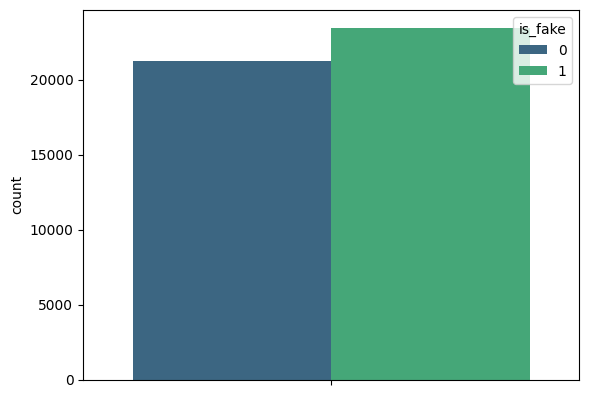

In [30]:
sns.barplot(df['is_fake'].value_counts().reset_index(), hue='is_fake', y='count', palette="viridis")
plt.show()

Бачимо що розподіл за класами приблизно однаковий, на 2.5% більше все таки фейкових новин. Далі здійснимо препроцесинг поля date, перетворимо в числовий формат

In [31]:
df.iloc[:10]['date']

0    September 17, 2017 
1           Jun 12, 2017
2         April 9, 2016 
3      December 2, 2017 
4      October 16, 2017 
5       November 2, 2017
6           Jul 28, 2015
7        August 24, 2017
8           Jul 28, 2017
9       October 9, 2017 
Name: date, dtype: object

Дата представлена в наступному форматі: `month day year`

In [32]:
df['date_changed'] = pd.to_datetime(df['date'].str.strip(), format='mixed', errors='coerce')

1 запис має зіпсований формат, видалимо його

In [33]:
df[df['date_changed'].isna()]

,title,text,date,is_fake,date_changed
15914,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,MSNBC HOST Rudely Assumes Steel Worker Would N...,1,NaT


In [34]:
df.dropna(inplace=True)
df.drop(columns='date', inplace=True)

In [35]:
df

,title,text,is_fake,date_changed
0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,0,2017-09-17
1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,1,2017-06-12
2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,0,2016-04-09
3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,0,2017-12-02
4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,0,2017-10-16
...,...,...,...,...
44675,"In new blow to campaign, Trump's foundation or...",WASHINGTON (Reuters) - New York’s attorney gen...,0,2016-10-03
44676,MICHELLE OBAMA’S Middle East Speech: Compares ...,Michelle Obama received $70 million dollars fr...,1,2015-11-06
44677,LEFTY COMMUNIST Calls Trump-Supporting High Sc...,"If you haven t discovered Austen Fletcher yet,...",1,2017-11-03
44678,SWISS ARMY CHIEF WARNS CITIZENS About Explosiv...,Wouldn t it be great if we had someone in gove...,1,2015-12-31


#### Здійснюємо обробку тексту, стеммінг, лематизація, видалення спецсимволів. Порахуємо частоту входжень слів

In [37]:
df['word_list'] = df['text'].apply(lambda x: process_text(x))

word_counter = Counter()

for word_list in df['word_list']:
    word_counter.update(word_list)

In [38]:
print("Кількість унікальних слів складає: {}".format(len(word_counter)))
print(f"Топ 20 слів покривають {round(100 * sum([value for key, value in word_counter.most_common(20)]) / sum(list(word_counter.values())), 2)}% усього набору даних")

Кількість унікальних слів складає: 121310
Топ 20 слів покривають 8.15% усього набору даних


Топ 20 найпопулярніших слів

In [39]:
count_words_df = pd.DataFrame({"words": word_counter.keys(),
                               "counts": word_counter.values()
                              }).sort_values(by='counts', ascending=False)
count_words_df['%'] = 100 * count_words_df['counts'] / sum(count_words_df['counts'].values)

count_words_df[:20]

,words,counts,%
47,trump,133449,1.250331
19,said,131629,1.233278
54,president,55594,0.520880
110,would,54810,0.513534
122,u,53752,0.503621
604,people,41659,0.390318
136,one,37777,0.353946
130,state,34273,0.321116
70,also,31157,0.291921
8,new,31152,0.291874


Додатково переглянемо слова з найбільшою частотою та переглянемо розподіл за таргетом

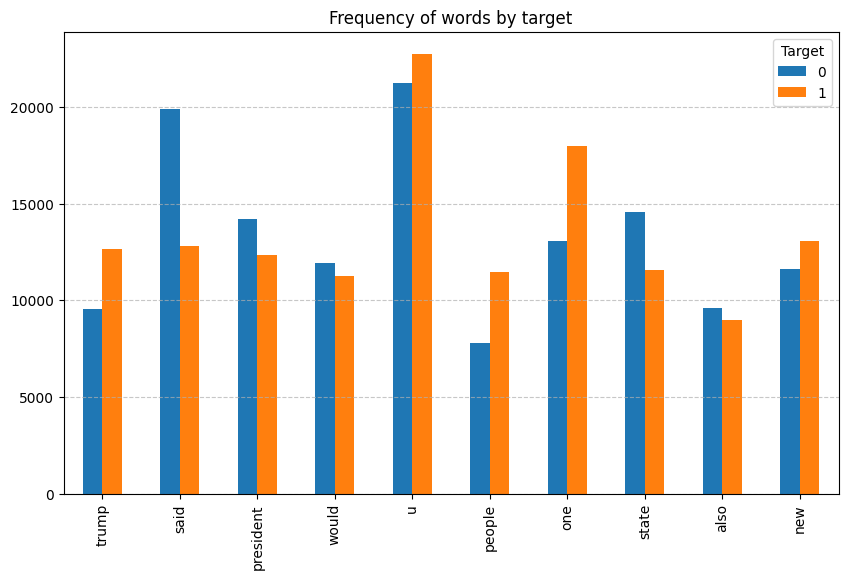

In [40]:
words = list([key for key, value in word_counter.most_common(10)])

counts = {}

for word in words:
    mask = df['text'].str.lower().str.contains(word)
    counts[word] = df[mask].groupby('is_fake').size()

df_counts = pd.DataFrame(counts).fillna(0).astype(int)
df_counts = df_counts.T

df_counts.plot(kind='bar', figsize=(10,6))

plt.title("Frequency of words by target")
plt.legend(title="Target")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Цікаво, що такі слова як `trump`, `people` мають явну схильність до вживань у фейкових новинах, в той час, як `said` використовуються в справжніх новинах. Припускаю, що словом `trump` та `people` кореспонденти спекулюють оскільки це гаряча тема в суспільстві, а слово `said` частіше використовується коли намагаються когось цитувати, а це легше відслідкувати та перевірити в інфопросторі

In [41]:
df['text_length'] = df['text'].apply(lambda x: len(x))

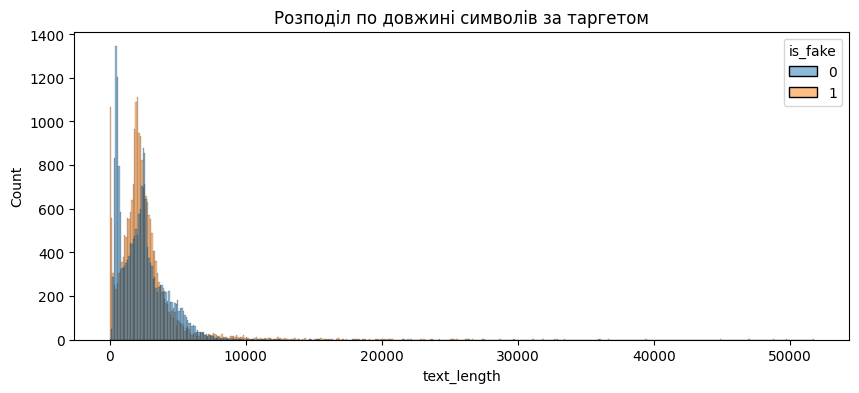

In [42]:
fig = plt.figure(figsize=(10,4))

sns.histplot(df, x='text_length', hue='is_fake')

plt.title("Розподіл по довжині символів за таргетом")
plt.show()

Обмежимо графік до 10000 символів у тексті

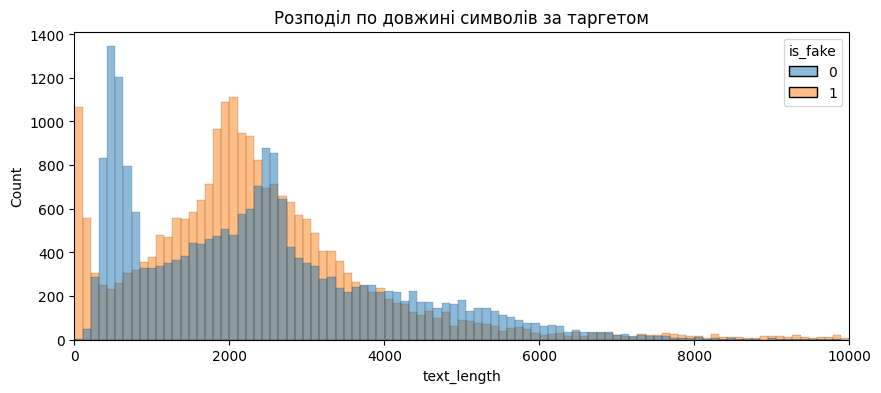

In [43]:
fig = plt.figure(figsize=(10,4))

sns.histplot(df, x='text_length', hue='is_fake')

plt.xlim(0, 10000)
plt.title("Розподіл по довжині символів за таргетом")
plt.show()

З даної діаграми видно, що новини, які мають приблизно до 100 символів - фейкові. Також кількість новин від 1500 до 2200 символів показують більшу залежність. В той час новини від від 100 символів до 800 символів в більшості реальні.

In [44]:
df.head()

,title,text,is_fake,date_changed,word_list,text_length
0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,0,2017-09-17,"[london, magnitude, 5, 9, earthquake, hit, coa...",305
1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,1,2017-06-12,"[hill, released, controversial, comments, sore...",1859
2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,0,2016-04-09,"[former, u, house, speaker, dennis, hastert, c...",1995
3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,0,2017-12-02,"[bucharest, romanian, protesters, clashed, rio...",2082
4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,0,2017-10-16,"[united, nations, democratic, republic, congo,...",2513


In [45]:
df.iloc[0]['word_list'][:10]

['london',
 'magnitude',
 '5',
 '9',
 'earthquake',
 'hit',
 'coast',
 'papua',
 'new',
 'guinea']

Здійснюємо TF-IDF трансформації для перетворення тексту в список та застосуємо стеммінг та лематизацію перед TF-IDF

In [48]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bilukhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bilukhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
df['word_list'] = [process_lemma_stemming(sentence) for sentence in df['word_list']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bilukhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bilukhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
X = tfidf_vectorizer.fit_transform([' '.join(sentence) for sentence in df['word_list']])

# Ансамбль моделей Logistic Regressin vs Decision Tree Classifier

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, df['is_fake'], test_size=0.25, random_state=42)

estimators = [
    ('decision_tree', DecisionTreeClassifier(
                        criterion='gini',     
                        max_depth=7,          
                        min_samples_split=10, 
                        min_samples_leaf=5,   
                        random_state=42           
                    )),
    ('logreg', LogisticRegression(solver='liblinear'))
    ]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train)
val_predictions = clf.predict(X_val)
train_predictions = clf.predict(X_train)

In [53]:
print("Train Accuracy: {:.2f}%".format(100 * accuracy_score(y_train, train_predictions)))
print("Train F1 score: {:.2f}%".format(100 * f1_score(y_train, train_predictions)))

print("Validation Accuracy: {:.2f}%".format(100 * accuracy_score(y_val, val_predictions)))
print("Validation F1 score: {:.2f}%".format(100 * f1_score(y_val, val_predictions)))

Train Accuracy: 98.73%
Train F1 score: 98.79%
Validation Accuracy: 98.17%
Validation F1 score: 98.26%


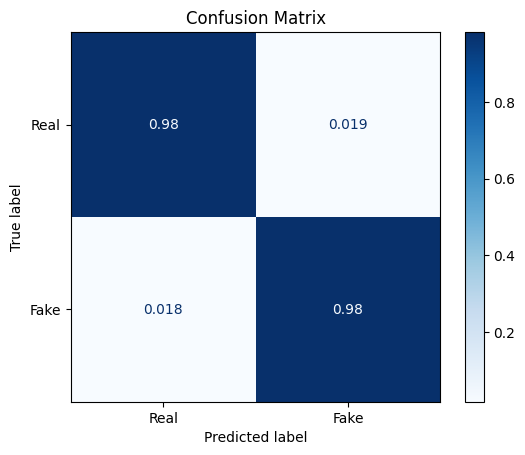

In [54]:
cm = confusion_matrix(y_val, val_predictions, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Bert

In [55]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['is_fake'], random_state=42, test_size=0.2)

dataset = DatasetDict({
    "train": Dataset.from_dict({"text": X_train, "labels": y_train}),
    "val": Dataset.from_dict({"text": X_val, "labels": y_val})
})

In [56]:
model_path = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "Not Fake", 1: "Fake"}
label2id = {"Not Fake": 0, "Fake": 1}

model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

/Users/bilukhan/Library/Python/3.12/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
# розморожуємо останні шари для файн тюнингу
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [58]:
# токенізуємо текст
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Токенізуємо весь датасет
tokenized_data = dataset.map(preprocess_function, batched=True)

# додаємо падінги до батчів
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/35743 [00:00<?, ? examples/s]

Map:   0%|          | 0/8936 [00:00<?, ? examples/s]

In [59]:
# hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 10

training_args = TrainingArguments(
    output_dir="fake-news-classifier",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=calculate_metrics,
)

trainer.train()

Тренування було запущене на GPU (NVIDIA A10 G) з 26GB пам'яті та зайняло близько 2-х годин. Завантажили дані в проект та працюємо вже з натренованою моделлю.

In [60]:
checkpoint_path = 'fake-news-classifier'

tokenizer = BertTokenizer.from_pretrained(checkpoint_path)
model = BertForSequenceClassification.from_pretrained(checkpoint_path)

Перевіримо роботу моделі на 1 тестовому прикладі

In [61]:
inputs = tokenizer(df.iloc[21492]['text'], truncation=True, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

print("Text: {}".format(df.iloc[21492]['text']))
print("Real label: {}".format(df.iloc[21492]['is_fake']))
print("Preicted label:", id2label.get(np.argmax(logits.detach().numpy())))

Text: We mentioned in an article yesterday that the real objective behind this recount effort is probably not to find voter fraud, but to strip Trump of the electoral votes in the traditionally blue, must-win states of PA, WI, and MI. If these state are in the process of a recount effort, Trump cannot use their electoral votes in the final tally. A Republican majority Congress would then have to vote to allow Trump to use the votes. The hope is likely that this action would throw Trump s presidency into question with voters, thus setting him up as an illegitimate President in the minds of American citizens. The good news is, the possiblity of a recount in the state of Pennsylvania with 20 electoral votes, is not looking too good for Hillary right now Jill Stein s Hillary Clinton s effort to recount presidential votes in three swing states already appears to be sputtering in Philadelphia.While Stein, a former presidential candidate, has raised millions of dollars and filed for a recount

Бачимо що модель працює, запускаємо предикт на усіх даних для оцінки

In [64]:
y_train = dataset['train']['labels']
train_predictions = []

for i in tqdm(range(dataset['train'].shape[0])):
    inputs = tokenizer(dataset['train'][i]['text'], truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    train_predictions.append(np.argmax(outputs.logits.detach().numpy()))


00%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.77it/s]

In [66]:
y_val = dataset['val']['labels']
val_predictions = []

for i in tqdm(range(dataset['val'].shape[0])):
    inputs = tokenizer(dataset['val'][i]['text'], truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    val_predictions.append(np.argmax(outputs.logits.detach().numpy()))


00%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.74it/s]

In [93]:
print("Train Accuracy: {:.2f}%".format(100 * accuracy_score(y_train, train_predictions)))
print("Train F1 score: {:.2f}%".format(100 * f1_score(y_train, train_predictions)))

print("Validation Accuracy: {:.2f}%".format(100 * accuracy_score(y_val, val_predictions)))
print("Validation F1 score: {:.2f}%".format(100 * f1_score(y_val, val_predictions)))

Train Accuracy: 99.33%
Train F1 score: 99.36%
Validation Accuracy: 99.33%
Validation F1 score: 99.36%


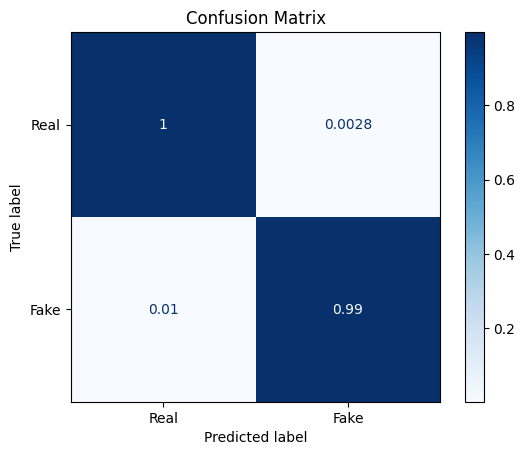

In [94]:
cm = confusion_matrix(y_val, val_predictions, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Файнтюнений BERT показав кращі результати, F1 score вищий на 1% за метрику ансамблю

# Fast Text

Напишемо функцію для формування 2-х наборів даних для входу моделі. Структура файлів наступна:
* **__label__FAKE fake news text**
* **__label__NOT_FAKE true news text**

In [87]:
train_df, val_df = train_test_split(df, test_size=0.2)

In [88]:
process_fasttext(train_df['text'], train_df['is_fake'], "train")
process_fasttext(val_df['text'], val_df['is_fake'], "val")

Тренуємо fasttext модель

In [89]:
model = fasttext.train_supervised(input="fast-text/train.txt", epoch=50, lr=1.0, wordNgrams=2, verbose=2)

Read 14M words
Number of words:  357035
Number of labels: 2
Progress: 100.0% words/sec/thread: 3063019 lr:  0.000000 avg.loss:  0.011930 ETA:   0h 0m 0s


In [116]:
y_train = train_df['is_fake']
train_predictions = []

for text in train_df['text']:
    train_predictions.append(1 if model.predict(text)[0][0] == '__label__FAKE' else 0)
    
y_val = val_df['is_fake']
val_predictions = []

for text in val_df['text']:
    val_predictions.append(1 if model.predict(text)[0][0] == '__label__FAKE' else 0)

In [117]:
print("Train Accuracy: {:.2f}%".format(100 * accuracy_score(y_train, train_predictions)))
print("Train F1 score: {:.2f}%".format(100 * f1_score(y_train, train_predictions)))

print("Validation Accuracy: {:.2f}%".format(100 * accuracy_score(y_val, val_predictions)))
print("Validation F1 score: {:.2f}%".format(100 * f1_score(y_val, val_predictions)))

Train Accuracy: 99.99%
Train F1 score: 99.99%
Validation Accuracy: 99.87%
Validation F1 score: 99.87%


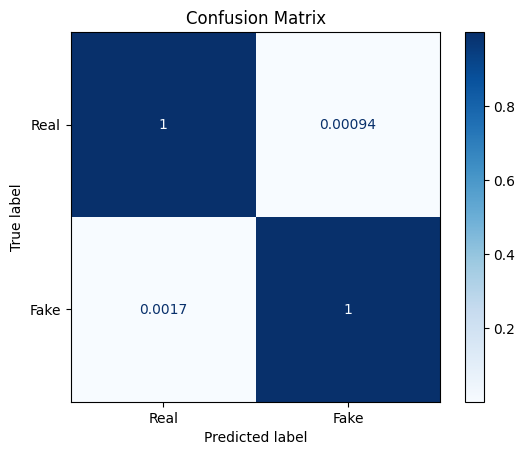

In [118]:
cm = confusion_matrix(y_val, val_predictions, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [120]:
print("News text: {}".format(df.iloc[1255]['text']))
print("Actual label: ", df.iloc[1255]['is_fake'])
print("Predicted label: ", model.predict(df.iloc[1255]['text'])[0])

News text: ISLAMABAD (Reuters) - A Pakistani court issued an arrest warrant for ousted Prime Minister Nawaz Sharif after he failed to appear before the court over anti-corruption allegations, local media said on Thursday, but he can avoid arrest by paying bail. In Pakistan,  bailable arrest warrants  often act as a warning to deter absences from court, but a judge can later issue non-bailable warrants that are more serious and could see Sharif arrested when he returns to Pakistan. Sharif missed the hearing as he is undertaking a religious pilgrimage in Saudi Arabia, Dawn and other English-language newspapers reported. Sharif had spent previous weeks tending to his wife in London, where she is receiving cancer treatment. Sharif faces three separate corruption charges from the National Accountability Bureau (NAB), an anti-corruption body which has its own courts. Sharif s two sons and his daughter Maryam, who is viewed as Sharif s heir-apparent, are also facing NAB trials. Sharif, 67, re

Отже, FastText справився найкраще з задачею класифікації фейкових новин, проте метрики показують, що BERT дав не набагато гірші результати, лише **0.5-0.6%** що є мізер в поєднанні з кастомним ансамблем